
# **Aurora DB Cluster**

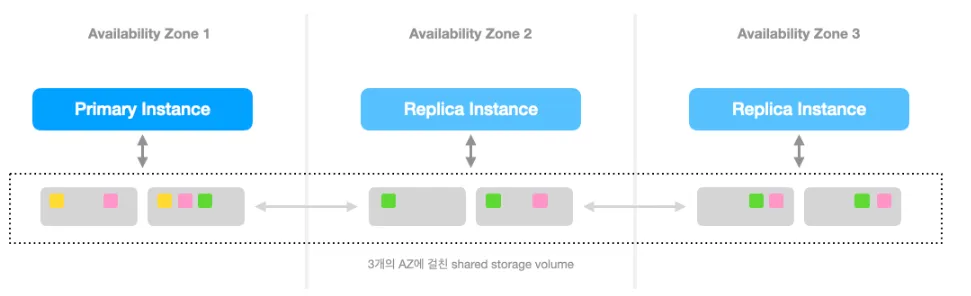

- 하나 이상의 DB 인스턴스와 DB 인스턴스의 데이터를 관리하는 클러스터 볼륨(스토리지 레이어)으로 구성
  - Primary Instance: 읽기/쓰기작업 지원, 클러스터 볼륨의 모든 데이터 수정을 실행
  - Aurora Replica: Primary와 동일한 스토리지 볼륨에 연결되고, 읽기 작업만 지원 (최대 15개)
- 스토리지는 3개의 가용 영역(AZ)에 걸쳐 있는 가상 디스크

**Aurora DB 성능**

- Aurora는 읽기와 쓰기 모두 인스턴스 크기에 따라 확장됨
- 기본적인 MySQL(RDS)는 동기식, 순차적인 과정에 따라 복제가 일어나기 때문에 I/O 작업이 굉장히 많음 (트랜잭션당 평균 7.4 I/O)

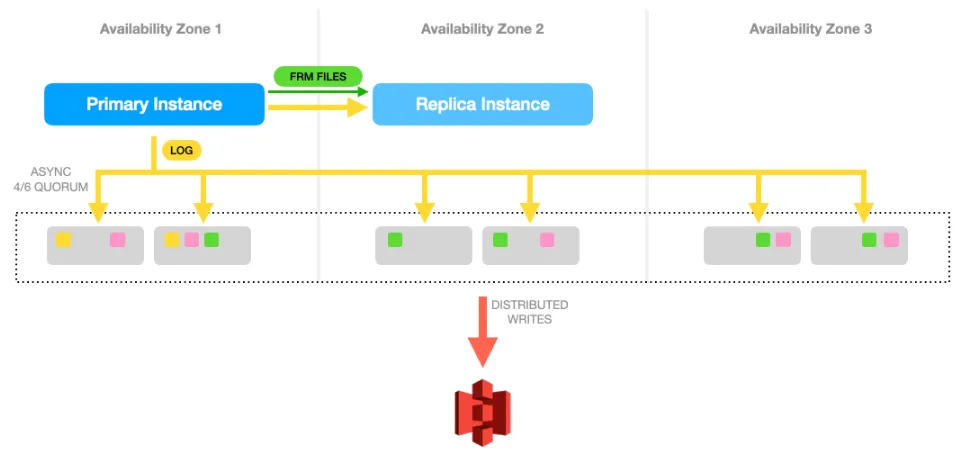

- primary에서 쓰기가 발생하면 6개의 스토리지 노드에 REDO 로그 레코드가 작성되며, 이중 4개의 노드가 ACK를 보내야 다음 작업으로 넘어가기 때문에 데이터베이스 시스템의 일관성, 내구성 ↑
- REDO 로그 레코드만 작성되면 primary 인스턴스는 다음 작업을 할 수 있기 때문에 기다리는 시간이 짧아 성능이 향상됨
- 6배 더 많은 로그를 쓰지만, 9배 더 적은 네트워크 트래픽 (트랜잭션당 평균 0.95 I/O)


**Aurora의 I/O 트래픽**


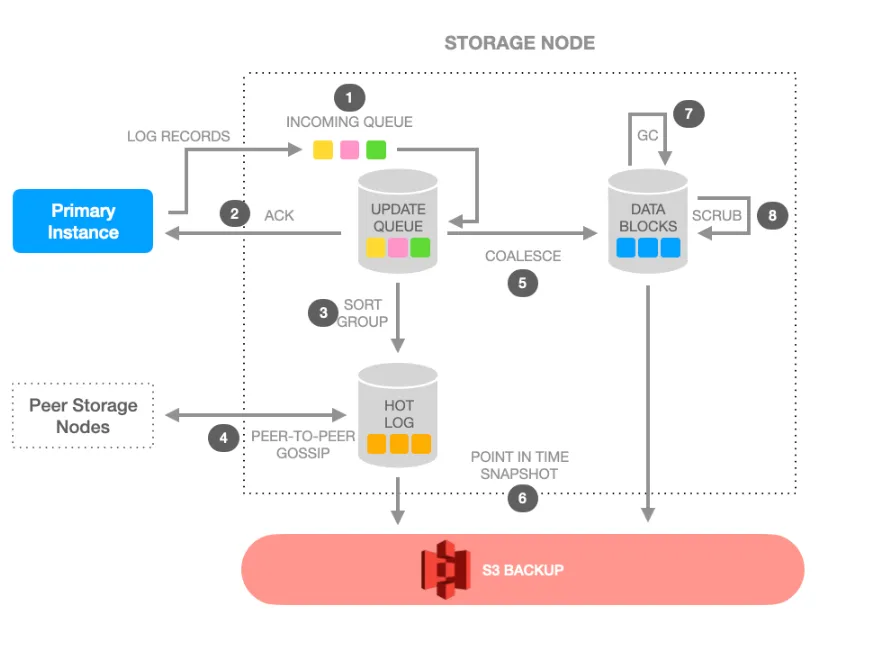

> 1. 레코드가 들어오면 incoming queue에 들어온 다음, 디스크에 씀
> 2. ACK를 반환
> 3. 비동기로 로그 레코드가 저장되었기 때문에 정렬과 그룹핑 작업을 통해 클린한 hot log를 만듬
> 4. 만약 로그 레코드에 빠진 데이터가 있다면 가십 프로토콜을 이용해 다른 스토리지 노드에게서 데이터를 받아옴
> 5. 최종적으로 redo 레코드를 데이터 페이지로 합치는 작업
> 6. 주기적으로 redo 레코드와 데이터페이지를 S3에 백업
> 7. garbage collect를 통해 오래된 버전 삭제
> 8. CRC 검사 수행


- 1, 2번까지가 foreground의 latency path에 속하기 때문에, 2번이 끝나면 primary 인스턴스는 다른 작업을 수행할 수 있음
- 지연에 민감한 작업에 강함
- 트래픽 급증시 디스크 공간을 버퍼로 사용


**복제시 Aurora I/O 트래픽**


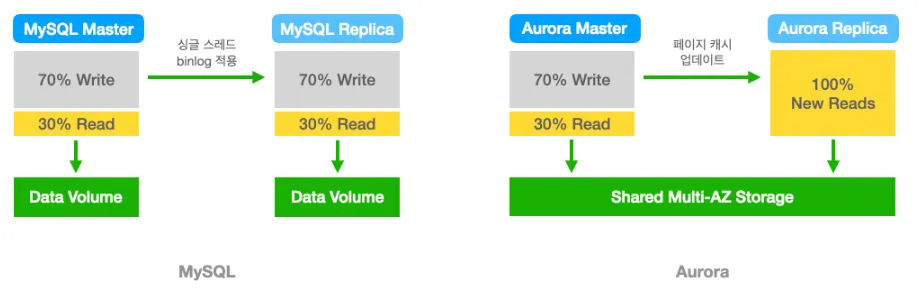

- 기존 MySQL에서는 빈로그를 이용해 SQL문을 복제본으로 전달하며, 마스터에서는 멀티 스레드로 수행하던 쿼리를 복제본에서는 싱글 스레드로 적용하기 때문에 처리 속도를 따라가기 어려움
- Aurora에서는 복제본에 redo 로그만 전송하기 때문에 write 없이 읽기만 하게 됨


**비동기 그룹 커밋**


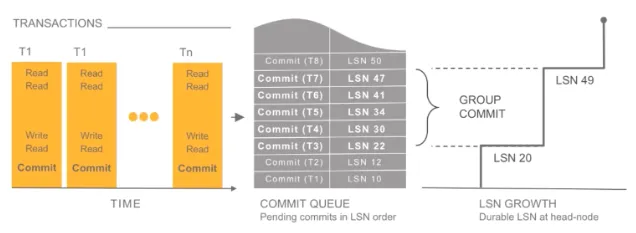

- 전통적으로는 로그 레코드가 쓰여질 때 버퍼를 유지하고, 버퍼가 가득차거나 타임아웃이 발생해야 디스크에 쓰여지며, 모든 작업은 동기적으로 진행됨 (DISK I/O)
- Aurora는 DISK I/O가 아닌 NW I/O를 요청하며, 작업의 길이와 상관 없이 버퍼를 채우고 처리하고를 반복하게 됨
  - latency penalty가 없음

**적응형 스레드 풀 (Adaptive Thread Pool)**


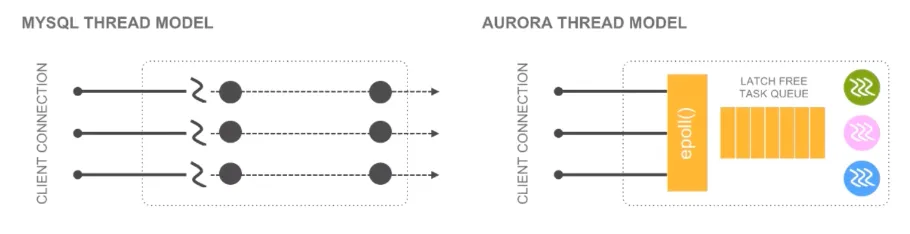

- Aurora에서는 적응형 스레드 풀을 이용해 병렬적으로 더 많은 작업을 수행할 수 있음
- MySQL에서는 커넥션당 하나의 스레드를 사용하지만 Aurora는 활성 스레드에 멀티플렉싱 커넥션을 재사용하며, 쓰레드 풀을 이용해 핸들링 할 수 있음

**lock 관리**


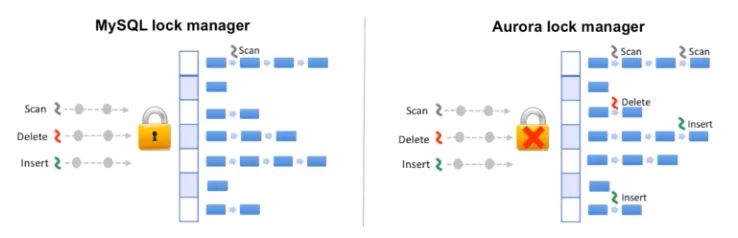

- Aurora는 lock chain에 대한 hash map을 생성하여 개별 lock chain의 동시 접근을 허용함
- 한번에 여러개의 작업을 동시에 수행할 수 있기 때문에 병렬 커넥션을 핸들링 할 수 있음
- lock-free 데드락 감지 가능

**기타 성능 향상**

- 캐시 읽기 성능 향상
  - 카탈로그 동시성
  - latch-free 동시 read view 알고리즘을 사용해서 read 성능 향상
- 비캐시 읽기 성능
  - 스마트 스케줄러
  - 스마트 셀렉터: 덜 바쁜 스토리지 노드를 찾아 데이터를 읽기 때문에 읽기 레이턴시 줄임
  - LRA(Logical read ahead): 블럭 순서가 아니라 B-tree 내의 순서를 기반으로 페이지를 프리패치해서 I/O를 줄일 수 있음
- 배치 삽입 성능
  - 불필요한 latch의 획득을 피하기 위해 배치 삽입시 이전의 커서를 기억하고 그 위치에서부터 데이터를 삽입함 (데이터가 PK에 의해 정렬되어있을 때)
- 빠른 인덱스 구축
  - 기존에는 인덱스를 만들때 리눅스의 read ahead 를 사용 (contiguous block address 이용)해서 top-down 방식으로 인덱스 빌드
  - aurora에서는 block 단위가 아니라 트리의 위치를 기반으로 block을 미리 가져옴
  - top-down이 아니라 bottom-up 방식으로 인덱스를 빌드 (leaf → branch)
  - split을 만들지 않으며, 각 페이지는 한번씩만 접근하고, 페이지당 하나의 로그 레코드를 가질 수 있도록 구현
  - MySQL에 비해 2~3배 빠르게 인덱스 구축

> 더 적은 I/O 수행, 네트워크 패킷 최소화, 비동기 처리, 지연을 줄여서 성능 향상



**Aurora 스토리지의 내구성**

- cluster volume은 SSD를 사용하는 단일 가상 볼륨
- primary DB 인스턴스에 데이터가 기록되면 Aurora에서는 가용 영역의 데이터를 클러스터 볼륨과 연결된 6개의 스토리지 노드에 **동기적으로 복제됨**
- 비영구적인 임시 파일을 위해서는 별도의 로컬 스토리지를 사용
- 데이터와 DB 인스턴스는 독립적으로 생성됨
  - 신규 인스턴스가 추가되어도 데이터를 새로 복사하지 않기 때문에 새로운 인스턴스를 빠르게 추가할 수 있음
  - 이미 모든 데이터가 포함된 공유 볼륨에 신규 DB 인스턴스가 연결됨
  - DB 인스턴스가 제거되는 경우에도 데이터가 삭제되지 않고, 전체 클러스터를 삭제할 때만 데이터가 제거됨
- 데이터베이스 데이터 용량이 늘어날수록 Aurora 클러스터 볼륨이 자동 확장됨
  - Aurora 2.09 이상, 3버전대에서는 데이터를 제거하면 클러스터 볼륨의 크기가 동적으로 조정되어 스토리지 비용을 줄일 수 있음
  - DROP TABLE , DROP DATABASE , TRUNCATE TABLE , DROP PARTITION 과 같은 SQL에서만 동적 크기 조정이 적용되고 , DELETE할 때에는 적용되지 않음
  - 대용량 DELETE를 했을 경우에는 OPTIMIZE TABLE 사용해서 테이블을 재구성해야 클러스터 볼륨의 크기를 동적으로 조정


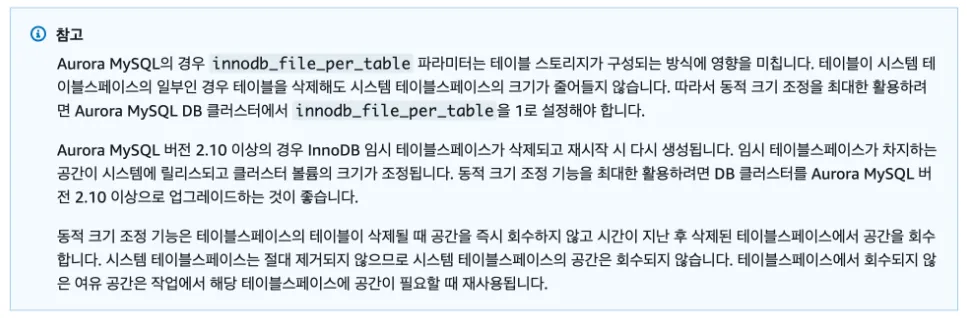

- 4/6 쿼럼을 사용하기 때문에 최소 4대 이상의 노드에서 데이터를 복제하며, 만약 최대 두대가 데이터를 받지 못했을 때에는 노드간 peer-to-peer gossip 프로토콜을 이용해 갭 데이터를 자동으로 채움
- disk volumne에서 장애를 자동으로 감지하고, 특정 세그먼트에 결함이 발생하면 aurora가 즉시 해당 세그먼트를 복구하며, 복구할 때에는 나머지 디스크 볼륨의 데이터를 사용
  - 데이터가 복제되어 있기 때문에 데이터 손실을 방지할 뿐 아니라 특정 시점으로 복구 기능할 필요성도 줄어듬
- 최대 64TB까지 성능 영향 없이 10GB 단위로 자동 확장
- cluster volume에 포함되는 항목: 사용자 데이터, 스키마 객체, 시스템 테이블, 빈로그와 같은 내부 메타데이터

**지속적 백업**


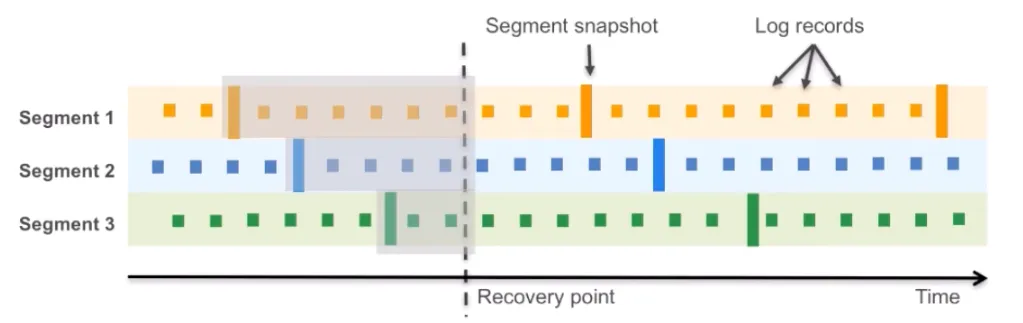

- 스토리지 노드는 로그 레코드를 받아서 LSN 기반으로 정렬, 비워있는 페이지를 채운 뒤 지속적으로 S3에 백업(스트리밍)
- 개별 레코드, 논리적으로 일관성 있는 스냅샷도 S3에 백업됨
- 복구할 때에는 특정 세그먼트 스냅샷 + 로그 레코드를 적용해서 recovery point로 복원 가능
- 복원 작업은 비동기, 병렬적으로 작업 가능하기 때문에 빠름

**crash 복구**

- 전통적으로는 마지막 체크포인트 이후의 로그를 리플레이 했어야 하고, 많은 디스크 I/O가 필요함
- Aurora에서는 redo로그를 리플레이
- Aurora는 거의 즉각적으로 복구되어 binlog 없이 어플리케이션 데이터를 계속 제공하도록 설계됨
- 병렬 스레드에서 비동기적으로 충돌 복구를 수행하여 데이터베이스가 오픈된 다음 충돌 후 즉시 사용될 수 있도록 함
- binlog 로깅
  - binlog 로깅을 활성화하면 강제로 binlog 복구를 수행하도록 하므로 충돌 후 복구 시간에 직접적인 영향을 줌
  - 사용되는 binlog 유형은 크기와 효율에 영향을 미침

**캐시 warming**


- 각 DB 인스턴스의 페이지 캐시가 데이터베이스와 별도의 프로세스로 관리되며, 페이지 캐시가 데이터베이스와 상관없이 유지됨
  - 페이지 캐시 → InnoDB 버퍼풀
- 데이터베이스 장애가 발생하면 페이지 캐시는 메모리에 남아 데이터베이스가 재시작될 때 유지되어, 워밍업 시간이 줄어들어 성능이 향상됨
  - writer 인스턴스가 재부팅될 때 reader 인스턴스가 재부팅되지 않으면 페이지 캐시가 손실되지 않음
  - writer 인스턴스가 재부팅될 때 reader 인스턴스가 재부팅되면 페이지 캐시가 손실됨
  - reader 인스턴스가 재부팅되면 writer 및 reader 인스턴스의 페이지 캐시가 모두 유지됨


**빠른 장애조치**

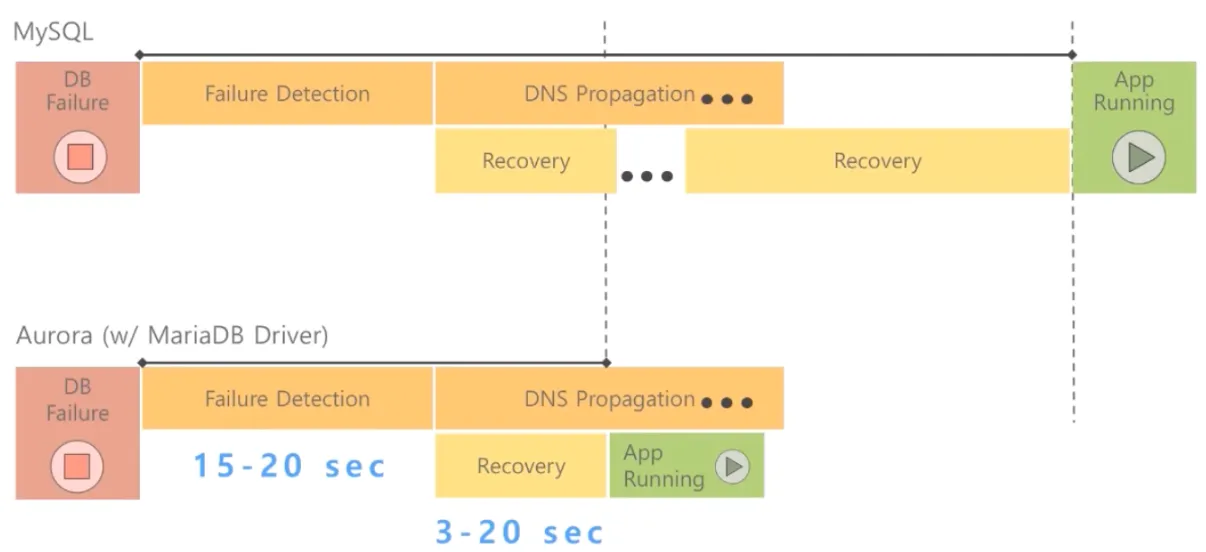

- 빠른 장애 감지
- 복구 시간은 3~20초 (대부분 DNS 전파)
- 장애조치
  - 클러스터에 복사본 instance가 있다면 primary로 승격 (30초 ~ 60초 미만)
  - 클러스터에 복제본이 없다면 동일한 AZ에 다시 생성됨 (10분 미만)


**Aurora Replica**

- 최대 15개의 복제본을 가질 수 있으며, 실패한 데이터베이스 프로세스는 자동으로 감지되고 재활용 됨
- reader endpoint를 이용해서 트래픽 처리 확장 가능
- 마스터 노드 failover시 승격될 replica노드들에 가중치를 둘 수 있음


**Aurora 3.0에서의 temp table 방식 차이**


**primary**



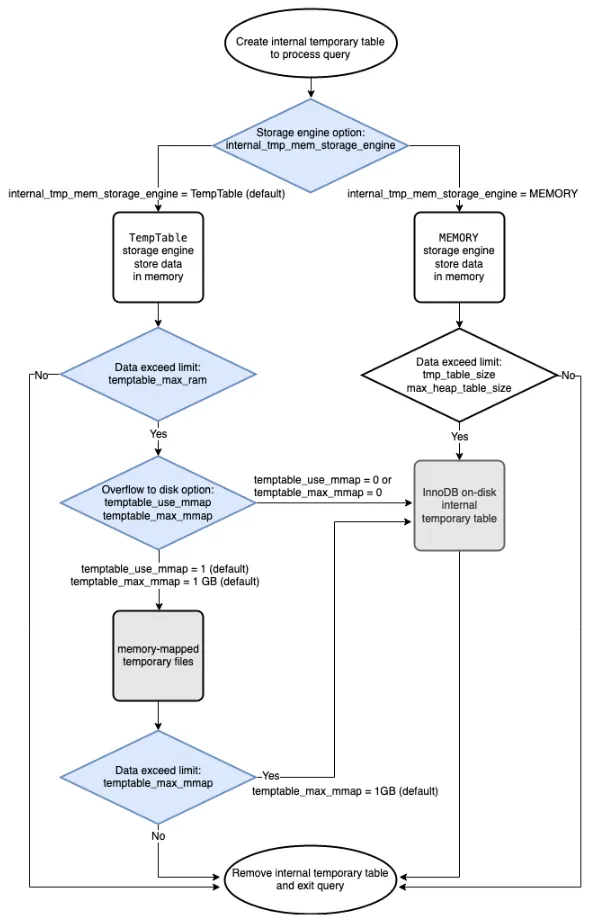

- TempTable 엔진을 사용해서 in memory 내부 임시 테이블
- 사이즈가 늘어나면 mmap 구조 사용 (로컬)
- 사이즈가 더 늘어나면 InnoDB on-disk 임시 테이블 사용


**replica**



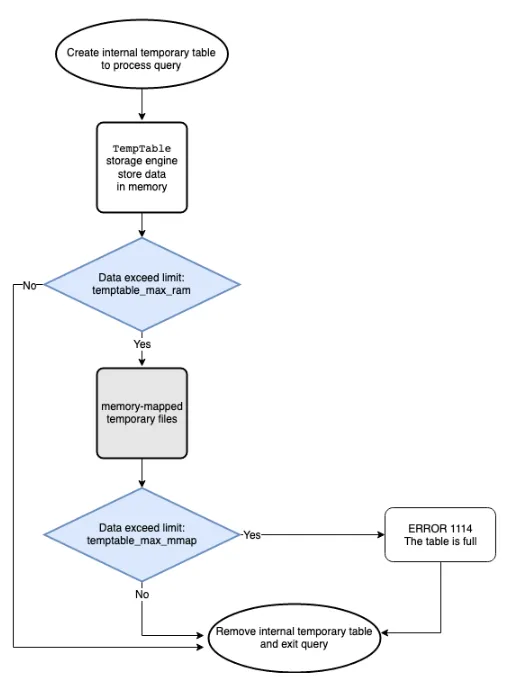

- internal_tmp_mem_storage_engine 은 TempTable이며 수정 불가
- temptable_use_mmap은 1이며 수정 불가
- temptable_max_mmap은 0으로 설정 불가


# **Aurora 심화**

**쿼럼(Quorum) 모델**

- 분산 스토리지에서 가용성과 정합성을 위해 쿼럼 모델을 사용
- 쿼럼 모델이 지켜야 하는 규칙

> 1. the read set, Vr, and the write set, Vw, must overlap on at least one copy
> 2. the quorum used for a write overlaps with prior write quorums

- **1번 규칙: 읽기 세트 Vr과 쓰기 세트 Vw가 최소 하나의 중첩된 복사본을 가져야 함**



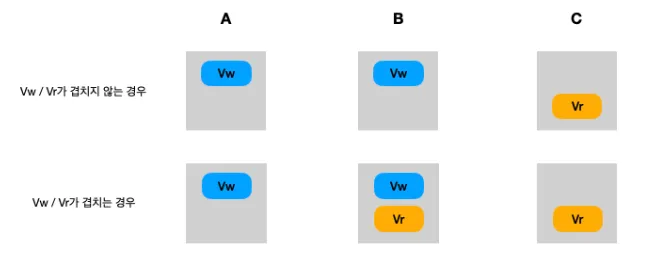

- 여러개의 복제본(copy == node)에 대해 Vw, Vr가 겹치지 않는 경우
  - A, B 노드에서는 쓰기에 대해 OK 하고 쓰고 있을 때, Vr에서 읽으면 보장되지 않은 데이터가 읽힐 수 있음
- 복제본 중 하나라도 Vw, Vr가 겹치는 경우
  - 보장되지 않는 데이터에 대해 read 하려 할 때 겹치는 노드 B에서 읽지 못하게 할 수 있음


- **2번 규칙: 쓰기에 사용된 쿼럼이 이전의 쓰기 쿼럼과 중첩되도록 해야 함**



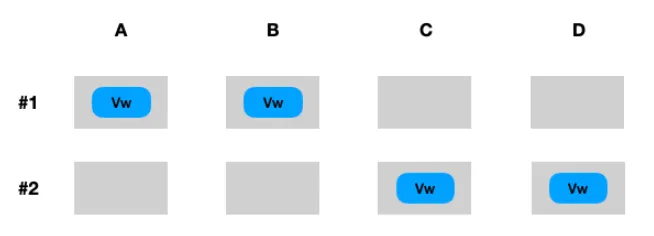

- Vw 노드가 중첩되지 않는 경우
  - 1번과 2번 트랜잭션에서 동일한 아이템을 수정하고 있다고 하더라도 2번 트랜잭션에서 C,D 노드가 찬성을 하면 쓰기 작업이 가능함
  - Vw > V/2로 보장 가능


**가능한 몇가지 모델**

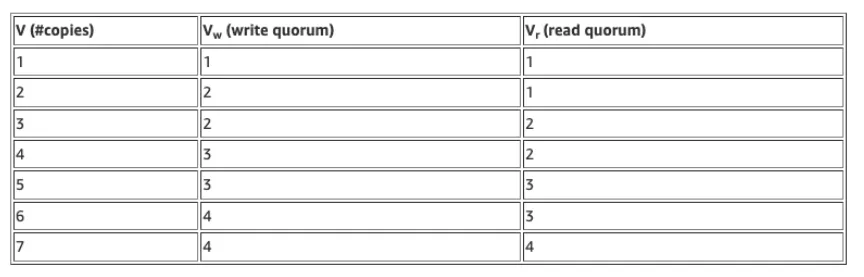

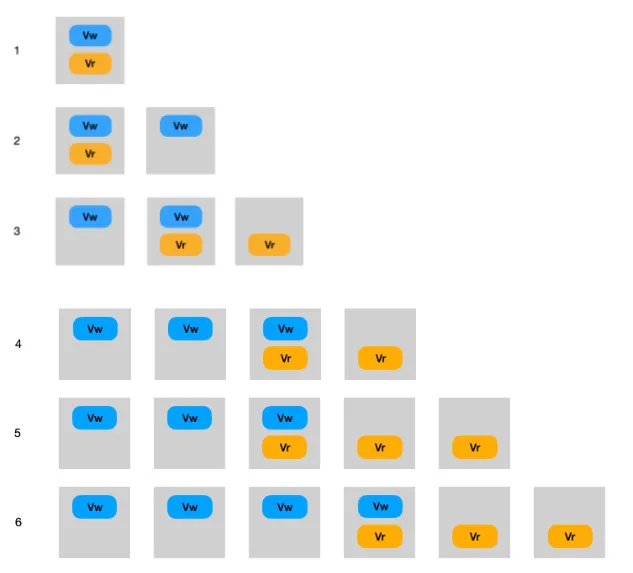

**Aurora에서 사용하는 쿼럼 정책**

- 3개의 AZ에 걸쳐 4개의 쓰기 세트와 3개의 읽기 세트가 있는 6개 복사본 쿼럼을 사용
  
  -> 여섯개의 복사본에 쓰기를 수행해서 네개의 복사본에서 완료를 받으면 쓰기가 완료됨

- 3개의 AZ에 걸쳐 노드를 분산하기 때문에, 그중 하나의 AZ가 다운되었다고 해도 내결함성을 유지할 수 있는 4/6 를 사용
  
  -> 한 AZ의 전체 손실 + 하나의 추가 오류에도 데이터 손실이 없게 유지할 수 있음

- Aurora의 평균 고장 시간 (MTTF)과 평균 수리 시간(MTTR)을 고려하면 6개의 복사본으로도 충분히 읽기 가용성을 지킬 수 있음
  
  -> 만약 재해로 인해 특정 AZ를 가동할 수 없다면 그 기간동안 degraded mode를 사용해서 쿼럼을 줄일 수 있음


**쿼럼으로 인한 읽기 속도 지연 이슈**

- Aurora는 3개의 읽기 쿼럼을 사용하기 때문에 3개 데이터를 읽어야 한다고 생각할 수 있음
- 하지만 aurora는 (MySQL의 MVCC 처럼) 상태(state) 정보를 사용
  - 읽기 시작하는 시점의 커밋 LSN을 가지고 그 이후 데이터가 존재하는 스토리지 읽기 노드로 읽기 요청을 전달
- 스토리지 노드의 읽기 요청 응답 시간을 추적하여 관리, 현재 가장 짧은 응답 시간을 제공하는 스토리지 노드를 조회하도록 함
- destructive(파괴적) 쓰기 방지
  - mysql에서 redo log는 롤백되더라도 항상 증가
  - 롤백을 하면 바로 데이터페이지 내용을 덮어쓰지 않고 별도 공간에 백업한 다음 이전 버전에 대해 가비지 콜렉션 작업을 진행


**다른 세그먼트 유형으로 인한 비용 절감**

- 6개의 복사본이 3개의 AZ에 분산되어 있지만 6개의 복사본이 모두 동일하지는 않음
  - Full Segment: 데이터 페이지와 로그 레코드를 모두 포함
  - Tail Segment: 로그 레코드만 포함
- Tail 세그먼트 중 하나에 오류가 발생하면 3개 복사본 중 하나로 쉽게 복구 가능
- Full 세그먼트 중 하나에 오류가 발생하면 최신 Full 세그먼트를 재생성할 수 있는 redo 로그가 있기 때문에 재생성 가능
- 쓰기 쿼럼은 모든 세그먼트 중 4개 or 3개의 풀 세그먼트 중 3개로 구성됨
- 읽기 쿼럼은 모든 세그먼트 중 3개 and 1개의 풀 세그먼트로 구성됨
  - 평소에는 읽기 쿼럼을 사용하지 않지만, 장애가 발생한 세그먼트의 rebuild 및 손상된 쿼럼을 복구하기 위해서 읽기 쿼럼을 사용함